In [ ]:
pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.2
    Uninstalling xgboost-2.1.2:
      Successfully uninstalled xgboost-2.1.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from yellowbrick.regressor import PredictionError, ResidualsPlot
import os
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#Read dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/ML/dataset/AB_NYC_2019.csv')
data.head()

Mounted at /content/drive


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


#EDA and Data Visualisations

Exploratory Data Analysis was performed on the dataset to have a better understanding of the dataset.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

###Room type analysis

In [ ]:
room_type = data.groupby('room_type').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()

room_type

,room_type,avg_price,count
0,Entire home/apt,211.794246,25409
1,Private room,89.780973,22326
2,Shared room,70.127586,1160


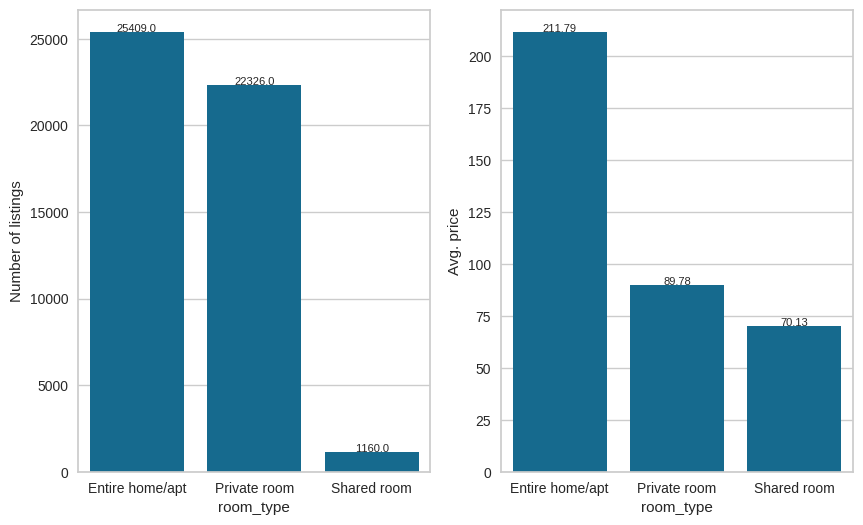

In [ ]:
fig,(chart_1,chart_2) = plt.subplots(1,2,figsize=(10,6))
ax = sns.barplot(x='room_type', y = 'avg_price', data=room_type, ax=chart_2)
for p in chart_2.patches:
    chart_2.annotate("{:.2f}".format(p.get_height()),
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center',
                     fontsize=8)
chart_2.set_ylabel("Avg. price")

ax = sns.barplot(x='room_type', y = 'count', data=room_type, ax=chart_1)
for p in chart_1.patches:
    chart_1.annotate("{:.1f}".format(p.get_height()),
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center',
                     fontsize=8)
chart_1.set_ylabel("Number of listings")
plt.show()

The dataset has 3 different room types:

*   52% (entire home/apartment)
*   45% (private room)
*   3% (shared room)


Also, Entire home/apt are most expensive.

###Neighbourhood_group(large area) analysis


In [ ]:
# avg price of neighbourhoods
neighbourhood_group_df = data.groupby('neighbourhood_group').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()

neighbourhood_group_df

,neighbourhood_group,avg_price,count
0,Bronx,87.496792,1091
1,Brooklyn,124.383207,20104
2,Manhattan,196.875814,21661
3,Queens,99.517649,5666
4,Staten Island,114.812332,373


Text(0, 0.5, '')

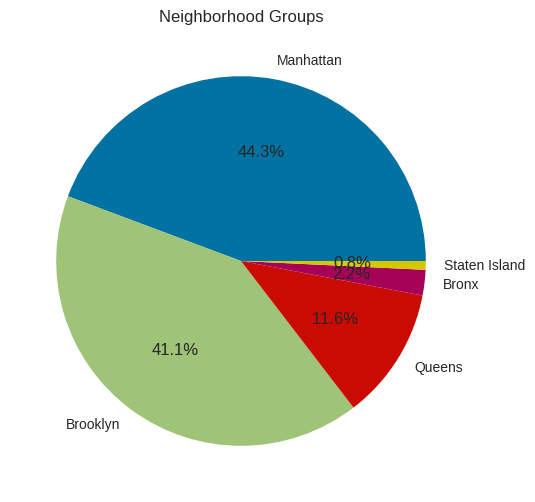

In [ ]:
#Pie chart to show listings in each neighbourhood group
ax1 = data.neighbourhood_group.value_counts().plot.pie(title='Neighborhood Groups',
                                               figsize=(6,6),
                                              autopct='%1.1f%%')
ax1.set_ylabel(None)

More than 85% of listings are located in Manhattan and Brooklyn.

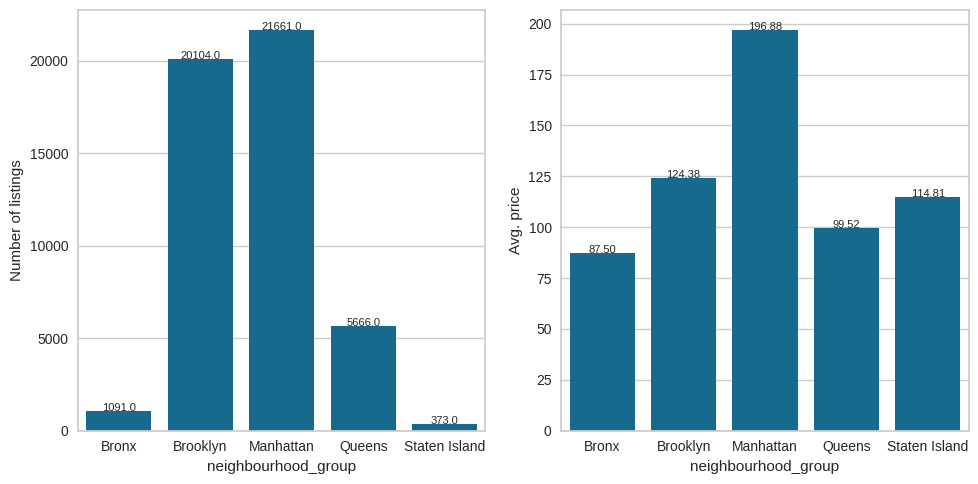

In [ ]:
fig,(chart_1,chart_2) = plt.subplots(1,2,figsize=(10,5))
ax = sns.barplot(x='neighbourhood_group', y = 'avg_price', data=neighbourhood_group_df, ax=chart_2)
for p in chart_2.patches:
    chart_2.annotate("{:.2f}".format(p.get_height()),
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center',
                     fontsize=8)
chart_2.set_ylabel("Avg. price")

ax = sns.barplot(x='neighbourhood_group', y = 'count', data=neighbourhood_group_df, ax=chart_1)
for p in chart_1.patches:
    chart_1.annotate("{:.1f}".format(p.get_height()),
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center',
                     fontsize=8)
chart_1.set_ylabel("Number of listings")
plt.tight_layout()
plt.show()

The pricing for the properties was skewed highly towards Manhattan at \$196, while all the other locations fell in the \$85-\$125 price range.

###Neighbourhood Analysis

In [ ]:
print("There are", data["neighbourhood"].nunique(), "distinct values.")

There are 221 distinct values.


Text(0.5, 1.0, 'Top 10 Neighbourhood')

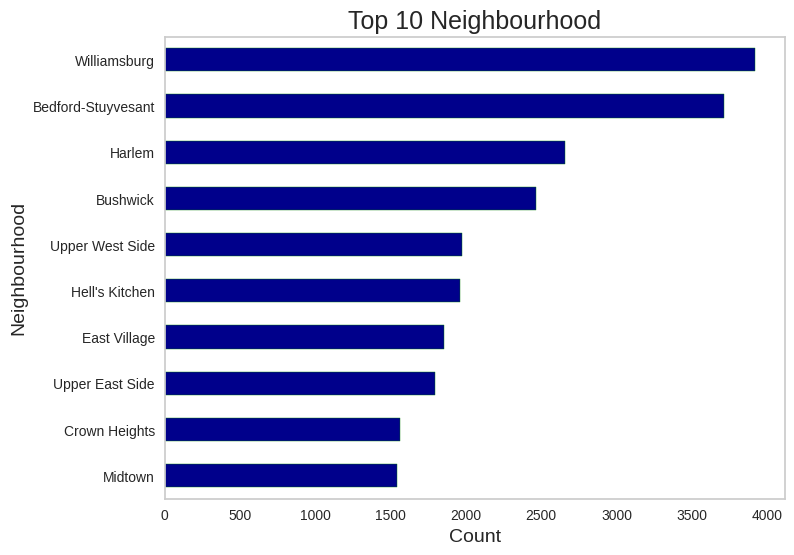

In [ ]:
plt.figure(figsize=(8,6))
data["neighbourhood"].value_counts().head(10).sort_values().plot(kind = "barh",
                                                               color = "darkblue",
                                                               edgecolor="green",
                                                               grid =False)
ax.bar_label(ax.containers[0], fmt='%.0f', color="black", fontsize=10)
plt.xlabel("Count", size = 14)
plt.ylabel("Neighbourhood", size = 14)
plt.title("Top 10 Neighbourhood", size = 18)

### neighbourhood_group and room type

<Axes: xlabel='longitude', ylabel='latitude'>

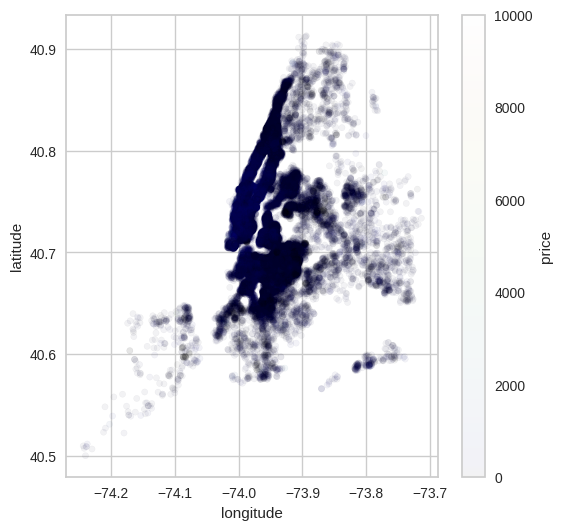

In [ ]:
data.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.05,
         figsize = (6,6), c = "price", cmap = plt.get_cmap("gist_earth"),
          colorbar = True
         )

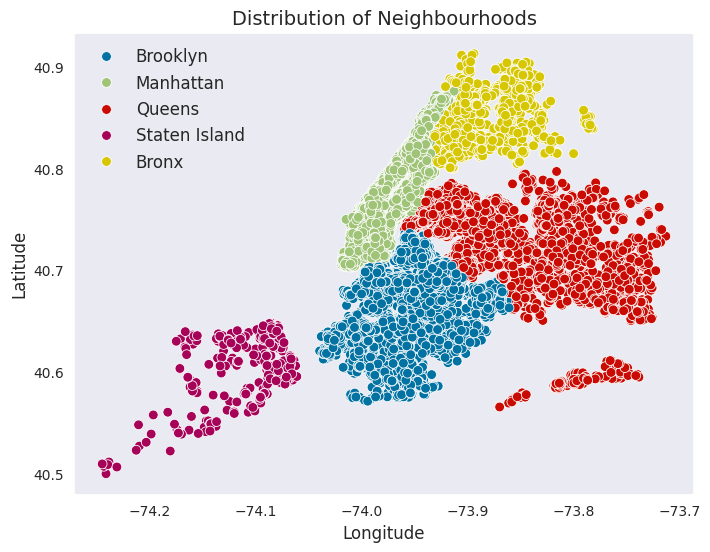

In [ ]:
plt.figure(figsize=(8,6))
sns.set_style("dark", {'axes.grid' : False})
sns.scatterplot(data=data, x="longitude", y="latitude", hue="neighbourhood_group")
plt.ylabel("Latitude", fontsize=12)
plt.xlabel("Longitude", fontsize=12)
plt.title("Distribution of Neighbourhoods", fontsize=14)
plt.legend(prop={"size":12})

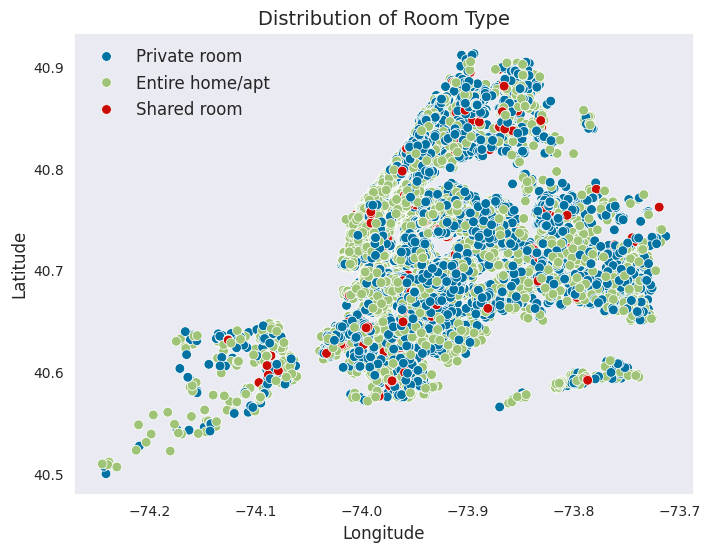

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = data, x="longitude", y="latitude", hue="room_type")
plt.ylabel("Latitude", fontsize=12)
plt.xlabel("Longitude", fontsize=12)
plt.title("Distribution of Room Type", fontsize=14)
plt.legend(prop={"size":12})

###Price Distribution analysis

Text(0.5, 1.0, 'Price Distribution After Log Transformation')

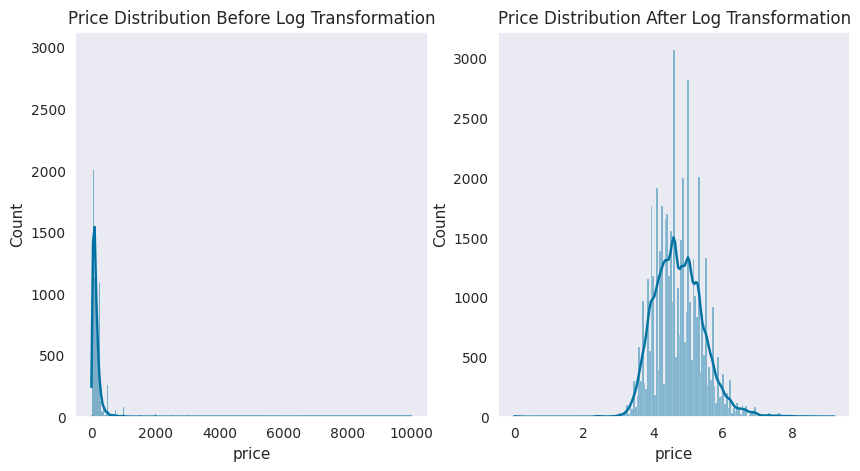

In [ ]:
#  log transformation
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.histplot(data=data, x="price", kde=True, ax=ax[0]).set_title("Price Distribution Before Log Transformation",
                                                                size = 12)
sns.histplot(np.log1p(data.price), kde=True, ax=ax[1]).set_title("Price Distribution After Log Transformation",
                                                                size = 12)

The graph on the left shows that there is a right skewed distribution. To make a better statistical analysis and to get better scores, we will be applied log transformation for the price column

#Data Cleaning and Preparation

##Outlier detection and Removal

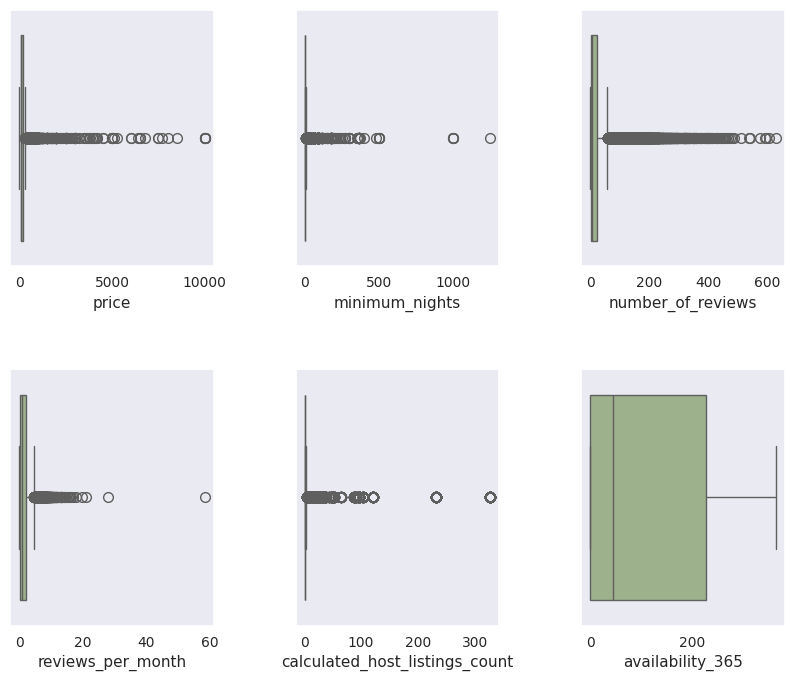

In [ ]:
columns = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count",
          "availability_365"]
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for num, column_name in enumerate(columns):
    ax = fig.add_subplot(2, 3, num +1)
    ax = sns.boxplot(x=data[column_name], color='#9db787')

In [ ]:
q1_price = data["price"].quantile(0.25)
q3_price = data["price"].quantile(0.75)
iqr_price = q3_price - q1_price
lower_limit_price = q1_price - 1.5 * iqr_price
upper_limit_price = q3_price + 1.5 * iqr_price

df_filter_price = data[(data["price"] > lower_limit_price) & (data["price"] < upper_limit_price)]


Text(0.5, 1.0, 'Price Distribution')

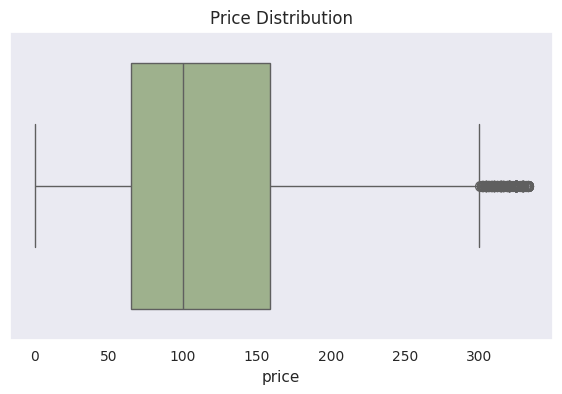

In [ ]:
fig = plt.figure(figsize=(7,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x=df_filter_price["price"], color='#9db787')
ax.set_title("Price Distribution")

In [ ]:
df = df_filter_price

##Correlation matrix

In [ ]:
# Check data types of all columns
print("Numeric columns:", df.select_dtypes(include=[np.number]).columns.tolist())
print("\nNon-numeric columns:", df.select_dtypes(exclude=[np.number]).columns.tolist())

Numeric columns: ['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Non-numeric columns: ['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']


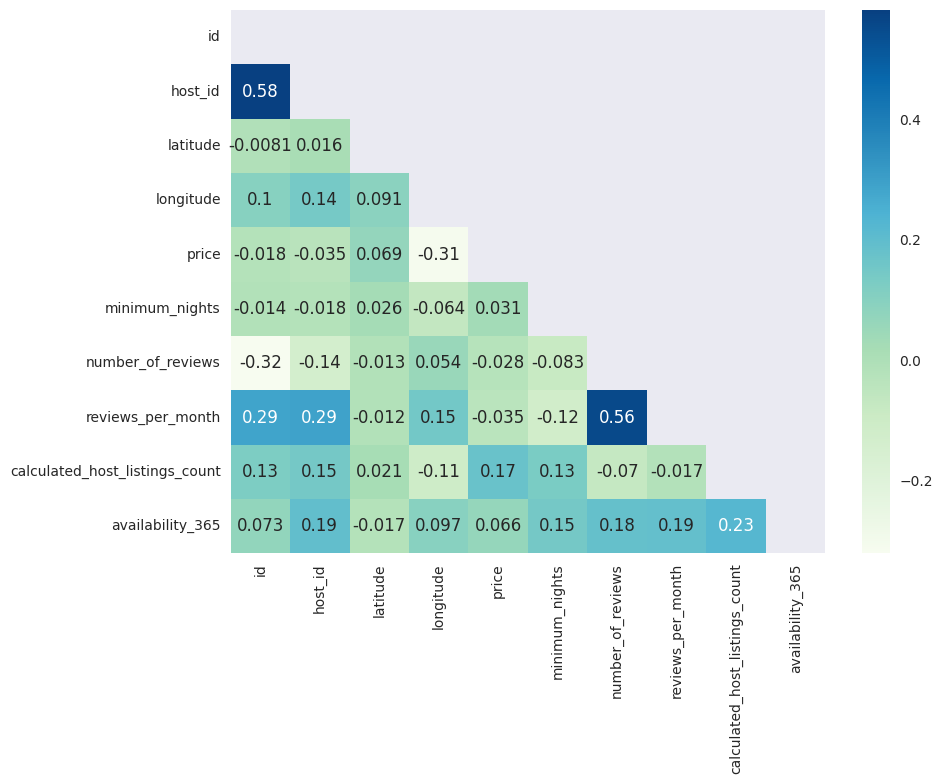

In [ ]:
# Get numeric columns only
numeric_df = df.select_dtypes(include=[np.number])

# Create the correlation heatmap
plt.figure(figsize=(10,8))
df_corr = numeric_df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, annot=True, cmap="GnBu")
plt.tight_layout()
plt.show()

## Handling Missing Values


In [ ]:
data.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [ ]:
data[data['last_review'].isnull()][['number_of_reviews','reviews_per_month']].head()

,number_of_reviews,reviews_per_month
2,0,NaN
19,0,NaN
26,0,NaN
36,0,NaN
38,0,NaN


In [ ]:
# filling non-values of 'reviews_per_month' with 0
data.fillna({'reviews_per_month':0}, inplace=True)
# Drop 'last_review' feature
data.drop('last_review', inplace=True, axis=1)
data.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


If a certain listing has a null for its "last_review," that means it has not gotten a review at all(also proved from previous dataframe), so "reviews_per_month" must be 0.

Also, now we can drop the last-review column containing null values from a cleaner dataset.


 drop the columns that will not affect the price prediction.

In [ ]:
data.drop(["id", "name", "host_id", "host_name"], axis = 1, inplace = True)

Applying log transformation for the price column.

In [ ]:
data["price"] = np.log1p(data["price"])
X = data.drop("price", axis = 1)
y = data["price"]

## Splitting data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

#Feature Encoding

Encoding is a vital process where categorical variable are transformed into numerical format. One-hot en-coding was adopted on ‘room type’, ‘neighbourhood group’, and ‘neighbourhood’. It was ensured that multi-collinearity was avoided while encoding. It resulted in a total of 235 features.

In [ ]:
# Usign One Hot Encoding
ohe = OneHotEncoder(handle_unknown = 'ignore')
columns = ["neighbourhood_group", "neighbourhood", "room_type"]
ohe_df_train = pd.DataFrame(ohe.fit_transform(X_train[columns]).toarray(), columns=ohe.get_feature_names_out())
X_train_ohe = X_train.join(ohe_df_train).drop(columns, axis=1)

ohe_df_test = pd.DataFrame(ohe.transform(X_test[columns]).toarray(), columns=ohe.get_feature_names_out())
X_test_ohe = X_test.join(ohe_df_test).drop(columns, axis=1)

#Feature Scaling

Feature scaling transforms numerical features to have the same range. Here, we utilised the standard scaler from the Scikit-Learn library

In [ ]:
# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_ohe)
X_test = scaler.transform(X_test_ohe)

#Model Building and Comparison

In [ ]:
classic_ml_models = []
ensemble_bagging_methods = []
ensemble_boosting_methods = []

Function for prediction and evaluation

In [ ]:
def test_models(X_train, X_test, y_train, y_test, model, model_name, models):
    y_pred = model.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = model.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())

    row = {"Model": model_name, "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}

    display(pd.DataFrame([row]))
    models.append(row)

Funtion for visualising the results together for comparison

In [ ]:
# Visualization Fuction
sns.set_style("dark", {'axes.grid' : False})
def compare_models(models, rotation):
    display(models.style.highlight_min(subset=["MAE","MSE","RMSE", "RMSE CV"], color = '#379949', axis = 0)\
                        .highlight_max(subset=["Test Sc."], color = '#379949', axis = 0)\
                        .highlight_min(subset=["Test Sc.",], color = '#b4241c', axis = 0)\
                        .highlight_max(subset=["MAE","MSE","RMSE", "RMSE CV"], color = '#b4241c', axis = 0))


##Classic ML models

###Ridge regression

In [ ]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, ridge, "Ridge Regression",classic_ml_models )

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Ridge Regression,0.550181,0.537237,0.334657,0.212804,0.461306,0.478069


###Lasso Regression

In [ ]:
lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, lasso, "Lasso Regression", classic_ml_models)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Lasso Regression,0.54993,0.537223,0.334679,0.212923,0.461435,0.477871


###Decision Tree

In [ ]:
# hyperparameter set to intermediate value of 60 to prevent underfitting/ overfitting
dtr = DecisionTreeRegressor(min_samples_leaf=60)
dtr.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, dtr, "Decision Tree", classic_ml_models)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Decision Tree,0.571749,0.600147,0.326018,0.2026,0.450111,0.467157


###Comparison of classic ML methods

In [ ]:
print("Green Highlights the best model, and Red highlights the worst.")
compare_models(pd.DataFrame(classic_ml_models),0)

Green Highlights the best model, and Red highlights the worst.


,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Ridge Regression,0.550181,0.537237,0.334657,0.212804,0.461306,0.478069
1,Lasso Regression,0.549930,0.537223,0.334679,0.212923,0.461435,0.477871
2,Decision Tree,0.571749,0.600147,0.326018,0.202600,0.450111,0.467157


 the Decision tree got the highest accuracy and the least errors

##Bagging Ensemble Methods

###Random Forest

In [ ]:
# Baseline random forest regression.
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, rfr, "Random Forest (Base)", ensemble_bagging_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Random Forest (Base),0.61025,0.942988,0.306271,0.184386,0.429402,0.447824




> Hyper parameter Tuning



In [ ]:
# Parameters currently in use for baseline model.
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rfr.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf_random = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=2
)


In [ ]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=5, n_jobs=2,
                   param_distributions={'max_depth': [10, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30}

In [ ]:
best_rf = rf_random.best_estimator_
test_models(X_train, X_test, y_train, y_test, best_rf, "Random Forest (Tunned)", ensemble_bagging_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Random Forest (Tunned),0.623237,0.819132,0.299825,0.178242,0.422187,0.441452


##Boosting Ensemble Methods

###Gradient Boosting

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)
test_models(X_train, X_test, y_train, y_test, gbr, "Gradient Boosting", ensemble_boosting_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Gradient Boosting,0.592386,0.590188,0.315598,0.192837,0.439132,0.453508


>Hyper-parameter Tuning

In [ ]:
from pprint import pprint
print('Parameters currently in use: \n')
pprint(gbr.get_params())

Parameters currently in use: 

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "alpha": [0.5, 0.9, 1.2, 1.5],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [5, 10, 15, 20, 30],
    "n_estimators": [100, 150, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}
gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = param_grid,
                               n_iter = 10, cv = 3, verbose=2, random_state=42,
                               n_jobs = -1)

In [ ]:
# Best parameters selected.
gbr_random.fit(X_train, y_train)
gbr_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'subsample': 1.0,
 'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 10,
 'learning_rate': 0.2,
 'alpha': 0.5}

In [ ]:
best_gbr = gbr_random.best_estimator_
test_models(X_train, X_test, y_train, y_test, best_gbr, "Gradient Boosting (Tunned)", ensemble_boosting_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Gradient Boosting (Tunned),0.619605,0.693612,0.304394,0.17996,0.424217,0.445204


###XGBoost

In [ ]:
xgbr = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
xgbr.fit(X_train,y_train)
test_models(X_train, X_test, y_train, y_test, xgbr, "XGBoost", ensemble_boosting_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,XGBoost,0.613338,0.692128,0.305603,0.182925,0.427697,0.444667




> Hyper-parameter Tuning



In [ ]:
from pprint import pprint
print('Parameters currently in use: \n')
pprint(xgbr.get_params())

Parameters currently in use: 

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None}


In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [10, 15, 20, 30],
    "n_estimators": [100, 150, 200, 300],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
}
xgbr_random = RandomizedSearchCV(estimator = xgbr, param_distributions = param_grid,
                               n_iter = 10, cv = 3, verbose=2, random_state=91,
                               n_jobs = -1)


In [ ]:
xgbr_random.fit(X_train, y_train)
xgbr_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'subsample': 0.6,
 'reg_lambda': 1.5,
 'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [ ]:
best_xgb = xgbr_random.best_estimator_
test_models(X_train, X_test, y_train, y_test, best_xgb, "XGBoost (Tunned)", ensemble_boosting_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,XGBoost (Tunned),0.622568,0.765177,0.301494,0.178558,0.422562,0.440758


###Comparison of Boosting Methods

In [ ]:
print("Green Highlights the best model, and Red highlights the worst!!!")
compare_models(pd.DataFrame(ensemble_boosting_methods),30)

Green Highlights the best model, and Red highlights the worst!!!


,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Gradient Boosting,0.592386,0.590188,0.315598,0.192837,0.439132,0.453508
1,Gradient Boosting (Tunned),0.619605,0.693612,0.304394,0.179960,0.424217,0.445204
2,XGBoost,0.613338,0.692128,0.305603,0.182925,0.427697,0.444667
3,XGBoost (Tunned),0.622568,0.765177,0.301494,0.178558,0.422562,0.440758


##Comparison of Ensemble methods

In [ ]:
print("Green Highlights the best model, and Red highlights the worst")
compare_models(pd.DataFrame(ensemble_bagging_methods+ensemble_boosting_methods),45)

Green Highlights the best model, and Red highlights the worst


,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Random Forest (Base),0.610250,0.942988,0.306271,0.184386,0.429402,0.447824
1,Random Forest (Tunned),0.623237,0.819132,0.299825,0.178242,0.422187,0.441452
2,Gradient Boosting,0.592386,0.590188,0.315598,0.192837,0.439132,0.453508
3,Gradient Boosting (Tunned),0.619605,0.693612,0.304394,0.179960,0.424217,0.445204
4,XGBoost,0.613338,0.692128,0.305603,0.182925,0.427697,0.444667
5,XGBoost (Tunned),0.622568,0.765177,0.301494,0.178558,0.422562,0.440758


##Comparing all models together

In [ ]:
compare_models(pd.DataFrame(classic_ml_models+ensemble_bagging_methods+ensemble_boosting_methods),60)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Ridge Regression,0.550181,0.537237,0.334657,0.212804,0.461306,0.478069
1,Lasso Regression,0.549930,0.537223,0.334679,0.212923,0.461435,0.477871
2,Decision Tree,0.571749,0.600147,0.326018,0.202600,0.450111,0.467157
3,Random Forest (Base),0.610250,0.942988,0.306271,0.184386,0.429402,0.447824
4,Random Forest (Tunned),0.623237,0.819132,0.299825,0.178242,0.422187,0.441452
5,Gradient Boosting,0.592386,0.590188,0.315598,0.192837,0.439132,0.453508
6,Gradient Boosting (Tunned),0.619605,0.693612,0.304394,0.179960,0.424217,0.445204
7,XGBoost,0.613338,0.692128,0.305603,0.182925,0.427697,0.444667
8,XGBoost (Tunned),0.622568,0.765177,0.301494,0.178558,0.422562,0.440758


#Comments

Of all the evaluated models and methods, the hyper-tuned XGBoost model gave the best results and the Lasso regression gave the worst results. The ensemble methods clearly outperform the classical machine learning models for Airbnb price prediction problem because it helps in the reduction in the variance component of prediction errors made by the contributing models. Moreover, the hyper-tuning further improved the results, which can be further enhanced using a grid search instead of a random search.

# Neural Networks

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [ ]:

ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = ann_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.7063 - mae: 1.3502 - val_loss: 0.4399 - val_mae: 0.4506
Epoch 2/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5346 - mae: 0.5599 - val_loss: 0.3246 - val_mae: 0.3970
Epoch 3/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4134 - mae: 0.4875 - val_loss: 0.3160 - val_mae: 0.3900
Epoch 4/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3514 - mae: 0.4465 - val_loss: 0.2996 - val_mae: 0.3684
Epoch 5/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3204 - mae: 0.4192 - val_loss: 0.2877 - val_mae: 0.3701
Epoch 6/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2830 - mae: 0.3938 - val_loss: 0.2690 - val_mae: 0.3554
Epoch 7/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2747 - mae: 0.3808 - val_loss: 0.2536 - val_mae: 0.3527
Epoch 8/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2502 - mae: 0.3650 - val_loss: 0.2665 - val_mae: 0.3644
Epoch 9/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

In [ ]:

# Evaluate
ann_pred = ann_model.predict(X_test)
print("\nArtificial Neural Network Results:")
print(f"MAE: {mean_absolute_error(y_test, ann_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ann_pred)):.4f}")
print(f"R2 Score: {r2_score(y_test, ann_pred):.4f}")


306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Artificial Neural Network Results:
MAE: 0.3298
RMSE: 0.4613
R2 Score: 0.5501


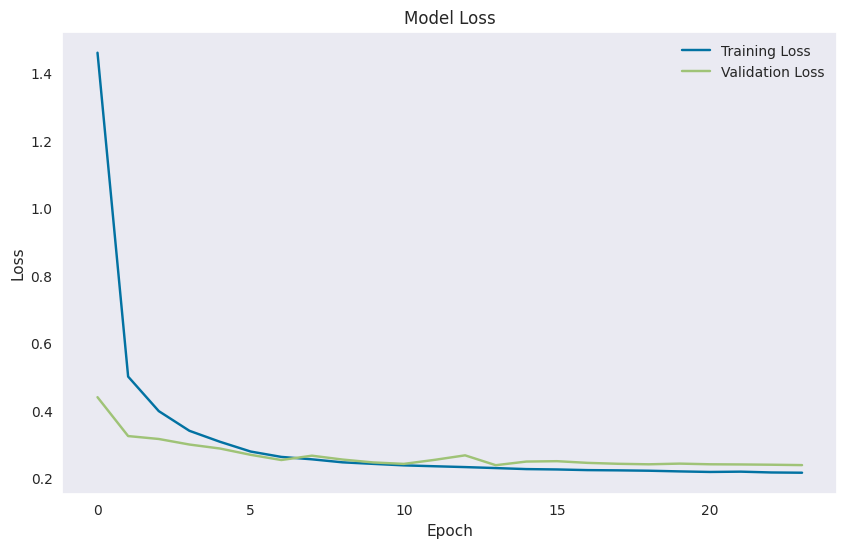

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Hyperparameter Tunning

In [ ]:
!pip install scikeras

###### Hyperparameter Tunning

In [ ]:
from scipy.stats import randint, uniform
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor

def create_model(neurons1=128, neurons2=64, neurons3=32, dropout1=0.3, dropout2=0.2, learning_rate=0.001):
    model = Sequential([
        Dense(neurons1, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout1),
        Dense(neurons2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout2),
        Dense(neurons3, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


param_dist = {
    'model__neurons1': randint(64, 256),
    'model__neurons2': randint(32, 128),
    'model__neurons3': randint(16, 64),
    'model__dropout1': uniform(0.1, 0.3),
    'model__dropout2': uniform(0.1, 0.3),
    'model__learning_rate': uniform(0.001, 0.01),
    'batch_size': randint(32, 64),
    'epochs': randint(50, 100)
}


model = KerasRegressor(model=create_model, verbose=0)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=2,
    n_jobs=1
)


random_search.fit(X_train, y_train)


print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Use best parameters to create final model
best_model = create_model(**{k.replace('model__', ''): v for k, v in random_search.best_params_.items()
                           if k.startswith('model__')})

# Train final model
final_history = best_model.fit(
    X_train, y_train,
    epochs=random_search.best_params_['epochs'],
    batch_size=random_search.best_params_['batch_size'],
    verbose=1
)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END batch_size=41, epochs=87, model__dropout1=0.1485219233572097, model__dropout2=0.3370253488136214, model__learning_rate=0.0041809010854051715, model__neurons1=109, model__neurons2=70, model__neurons3=32; total time= 2.4min
[CV] END batch_size=41, epochs=87, model__dropout1=0.1485219233572097, model__dropout2=0.3370253488136214, model__learning_rate=0.0041809010854051715, model__neurons1=109, model__neurons2=70, model__neurons3=32; total time= 1.9min
[CV] END batch_size=41, epochs=87, model__dropout1=0.1485219233572097, model__dropout2=0.3370253488136214, model__learning_rate=0.0041809010854051715, model__neurons1=109, model__neurons2=70, model__neurons3=32; total time= 2.0min
[CV] END batch_size=36, epochs=99, model__dropout1=0.14294668256567616, model__dropout2=0.11323830608935137, model__learning_rate=0.004391039777312497, model__neurons1=237, model__neurons2=113, model__neurons3=17; total time= 2.4min
[CV] END batch

In [ ]:
y_pred = best_model.predict(X_test)

print('Hypertuned Model Test Results:')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')
print(f'R2 Score: {r2_score(y_test, y_pred):.4f}')

306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Hypertuned Model Test Results:
MAE: 0.3203
RMSE: 0.4480
R2 Score: 0.5757


While the prediction enhanced after hyperparametertunning, our artificial neural network is not efficient as the Random Forest model.